In [60]:
import os, subprocess
out = subprocess.run(["uname", "-a"], capture_output=True)
if "Darwin" in str(out.stdout):
    print('overriding PATH')
    os.environ['PATH'] = "/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:" +  os.environ['PATH']

overriding PATH


In [61]:
# Orchestration/Data Extraction function defs

from collections import defaultdict
import re
import os
from pathlib import Path
import subprocess
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib_venn import venn3, venn2

success_column = "Passed"
#success_column = "RejudgementPassed"
#success_column = "ConsensusPassed"


def invert_mapping(dictionary: dict) -> dict:
    return {elem: k for k, v in dictionary.items() for elem in v}

figure_annotations = {
    "child_benefit": {
        "success_rates_by_permutation_model_size.hist": {
            "title": "Accuracy of agent (according to judge) for child benefit",
            "ylabel": "Count",
            "xlabel": "Percentage correctness over all executions"
        },
        "success_rates_by_permutation_model_size.improvement.hist": {
            "title": "Difference in judged accuracy with varying model size for child benefit",
            "ylabel": "Count of permutations",
            "xlabel": "Large model accuracy % minus small model accuracy % for a given permutation",
        },
        "success_rates_by_eligibility.hist": {
            "ylabel": "Count of permutations",
            "xlabel": "Model Accuracy %"
        },
        "success_rates_by_eligibility.modelSize": {
            "ylabel": "Model Size",
            "xlabel": "Eligibility Category",
            "title": "Average judged accuracy for model size and eligibility category",
        },
    },
    "skilled_worker_visa": {
        "success_rates_by_permutation_model_size.hist": {
            "title": "Accuracy of agent (according to judge) for skilled worker visa",
            "ylabel": "Count",
            "xlabel": "Percentage correctness over all executions"
        },
        "success_rates_by_permutation_model_size.improvement.hist": {
            "title": "Difference in judged accuracy with varying model size for skilled worker visa",
            "ylabel": "Count of permutations",
            "xlabel": "Large model accuracy % minus small model accuracy % for a given permutation",
        },
        "success_rates_by_eligibility.hist": {
            "ylabel": "Count of permutations",
            "xlabel": "Model Accuracy %"
        },
        "success_rates_by_eligibility.modelSize": {
            "ylabel": "Model Size",
            "xlabel": "Eligibility Category",
            "title": "Average judged accuracy for model size and eligibility category",
        },
    },
    "child_benefit__stressTestAgent": {
        "success_rates_by_permutation_model_size.hist": {
            "title": "Accuracy of agent (according to judge) for child benefit",
            "ylabel": "Count",
            "xlabel": "Percentage correctness over all executions"
        },
        "success_rates_by_permutation_model_size.improvement.hist": {
            "title": "Difference in judged accuracy with varying actor prompt for child benefit",
            "ylabel": "Count of permutations",
            "xlabel": "Helpful Actor accuracy % minus Realistic Actor accuracy % for a given permutation",
        },
        "success_rates_by_eligibility.hist": {
            "ylabel": "Count of permutations",
            "xlabel": "Accuracy %"
        },
        "success_rates_by_eligibility.modelSize": {
            "ylabel": "Actor",
            "xlabel": "Eligibility Category",
            "title": "Average judged accuracy for Actor Prompt and Eligibility Category",
        },
    },
}

model_sizes_hypothesis_mapping = {
    "child_benefit": {"baseline": "gemma4B", "improved": "gemma27B"},
    "skilled_worker_visa": {"baseline": "gemma4B", "improved": "gemma27B"},
    #"child_benefit__stressTestAgent": {"baseline": "gemma27B", "improved": "claude37Sonnet"},
    #"child_benefit__stressTestAgent": {"baseline": "claude37Sonnet__Realistic", "improved": "claude37Sonnet__Helpful"},
    "child_benefit__stressTestAgent": {"baseline": "Realistic", "improved": "Helpful"},
}

model_size_commit_mapping = {
    "child_benefit": invert_mapping({
        "gemma4B": ["Unknown", "fc922c5", "9493282", "f2dc127"],
        "gemma27B": ["575b5e9"],
    }),
    "skilled_worker_visa": invert_mapping({
        "gemma4B": ["Unknown", "db37bc9", "df1795d", "71b1d7c"], 
        "gemma27B": ["8ed3c90"]
    }),
    "child_benefit__stressTestAgent": invert_mapping({
        #"gemma27B": ["1012a61", "976499a", "74e8834"], 
        #"claude37Sonnet": ["e680f99"],
        #"claude37SonnetOriginalPrompt": ["21506e4"],
        "Realistic": ["10c6f19"],
        "Helpful": ["d6dfd9f"],
    }),
    #defaultdict(lambda: "large"),
}

# TODO extract this from model_sizes_hypothesis mapping and model_sizes_commit_mapping
commits_to_filter = {
    "child_benefit__stressTestAgent": ["10c6f19", "d6dfd9f"],
    #"skilled_worker_visa": ["Unknown", "db37bc9", "df1795d", "71b1d7c", "8ed3c90"],
    #"child_benefit": ["Unknown", "fc922c5", "9493282", "f2dc127", "575b5e9"],
}

def extract_judgement_results_for_folder(output_dir, search_character) -> pd.DataFrame:
    extracted_records = []
    output = subprocess.run(
        [
            "rg", 
            search_character, 
            str(Path(os.getcwd()).joinpath(output_dir)),
            "--hidden"
        ],
        capture_output=True,
        check=False,
        text=True,
        cwd=Path(os.getcwd()).joinpath(output_dir)
        #cwd=output_dir,
    )
    print(output.stderr)
    output.check_returncode()
    for filename in output.stdout.strip().split("\n"):
        if filename:
            with_commit = (
                r".*(?P<exec_time>[\d:T\.-]+)__RepoCommit=(?P<commit>[a-f0-9]+)/Permutation(?P<permutation>\d+)__rejudgement_(?P<rejudgement_time>[\d:T\.-]+).*"
                #  + ur":\[evaluation_judge\]: "
                + search_character + r"(?P<rejudgement_reasoning>.*)"
            )
            if re.match(
                with_commit,
                filename,
                re.UNICODE
            ):
                extracted_fields = re.search(
                    with_commit,
                    filename,
                    re.UNICODE
                ).groupdict()
            extracted_fields["permutation"] = int(extracted_fields["permutation"])
            extracted_fields["rejudgement_reasoning"] = str(extracted_fields["rejudgement_reasoning"])
            extracted_records.append(extracted_fields)
    df = pd.DataFrame.from_records(
        extracted_records,
        columns=["exec_time", "commit", "permutation", "rejudgement_time", "rejudgement_reasoning"]
    )
    df = df[df['commit'].isin(commits_to_filter[output_dir.name])]
    return df


def extract_results_for_folder(output_dir, search_character) -> pd.DataFrame:
    print(output_dir)
    extracted_records = []
    output = subprocess.run(
        [
            "rg", 
            search_character, 
            "--hidden",
            str(Path(os.getcwd()).joinpath(output_dir)),

        ],
        capture_output=True,
        check=False,
        text=True,
        #cwd=output_dir,
        #cwd=Path(os.getcwd()).joinpath(output_dir)

    )
    print(output.stderr)
    output.check_returncode()
    for filename in output.stdout.strip().split("\n"):
        if filename:
            with_commit = (
                r".*(?P<exec_time>[\d:T\.-]+)__RepoCommit=(?P<commit>[a-f0-9]+)/Permutation(?P<permutation>\d+).*"
                #  + ur":\[evaluation_judge\]: "
                + search_character + r"(?P<reasoning>.*)"
            )
            if re.match(
                with_commit,
                filename,
                re.UNICODE
            ):
                extracted_fields = re.search(
                    with_commit,
                    filename,
                    re.UNICODE
                ).groupdict()
            else:
                without_commit = (
                    r".(?P<exec_time>[\d:T\.-]+)/Permutation(?P<permutation>\d+).out.*"
                    #  + ur":\[evaluation_judge\]: "
                    + search_character + r"(?P<reasoning>.*)"
                )
                extracted_fields = re.search(
                    without_commit,
                    filename,
                    re.UNICODE
                ).groupdict()
            extracted_fields["permutation"] = int(extracted_fields["permutation"])
            extracted_fields["reasoning"] = str(extracted_fields["reasoning"])
            extracted_records.append(extracted_fields)
    df = pd.DataFrame.from_records(
        extracted_records,
        columns=["exec_time", "commit", "permutation", "reasoning"]
    )
    df = df[df['commit'].isin(commits_to_filter[output_dir.name])]
    return df


def load_and_parse_test_cases(test_cohort: str) -> list[str]:
    test_case_file = (
        Path("../") # Repository root
        .joinpath(f"prompts/manual/test_cases/")
        .joinpath(test_cohort.split("__")[0] + ".md")
    )
    with test_case_file.open() as f:
        raw_test_cases = f.readlines()
    test_cases_str = "\n".join(raw_test_cases)
    test_cases = test_cases_str.split(sep="---")
    return test_cases


def extract_test_cases_for_test_cohort(test_cohort) -> pd.DataFrame:
    test_cases = load_and_parse_test_cases(test_cohort)
    extracted_records = []
    for test_case in test_cases:
        parsed_test_case = list(filter(len, test_case.split("\n")))
        extracted_records.append(
            dict(
                permutation=extract_permutation_number_from_test_case(parsed_test_case),
                #  "eligible": extract_eligibility_from_test_case(parsed_test_case),
                **extract_eligibility_from_test_case(parsed_test_case),
            )
        )
    return pd.DataFrame.from_records(extracted_records, index="permutation")


def extract_eligibility_from_test_case(test_case):
    outcome = test_case[-1]
    assert "**Outcome:**" in outcome, outcome
    #  assert outcome.count("Eligible") == 1, outcome

    return {
        "not_eligible": bool(outcome.count("Not Eligible")),
        # If we find the words Eligible outside of the string "Not Eligible" (as the former is a substring of the latter we can just subtract occurrences) then we know the results is partial eligibility
        "eligible": bool(outcome.count("Eligible") - outcome.count("Not Eligible")),
    }


def extract_permutation_number_from_test_case(test_case):
    permutation = test_case[0]
    p_match = re.search(r"Permutation (?P<permutation_number>[\d]+):", permutation)
    assert p_match and len(p_match.groups()) == 1
    return int(p_match.groups()[0])


def get_eligibility_case(row):
    match (row["eligible"], row["not_eligible"]):
        case (True, True):
            return "Both"
        case (True, False):
            return "Eligible"
        case (False, True):
            return "NotEligible"


def load_failure_df(output_dir, test_cohort) -> pd.DataFrame:
    #  print('failures:')
    df = extract_results_for_folder(output_dir, "✗")
    df["Passed"] = False
    if len(df) > 0:
        df["commit"].fillna("Unknown", inplace=True)
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    df["ModelSize"] = df.index.get_level_values(0).map(
        model_size_commit_mapping[test_cohort]
    )
    #  print(df.value_counts(["permutation", "ModelSize"]))
    return df

def load_disagree_judgements_df(output_dir, test_cohort) -> pd.DataFrame:
    df = extract_judgement_results_for_folder(output_dir, "☹")
    df["RejudgementAgree"] = False
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    return df

def load_agree_judgements_df(output_dir, test_cohort) -> pd.DataFrame:
    df = extract_judgement_results_for_folder(output_dir, "☺")
    df["RejudgementAgree"] = True
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    return df

def load_failed_judgements_df(output_dir, test_cohort) -> pd.DataFrame:
    df = extract_judgement_results_for_folder(output_dir, "👎")
    df["RejudgementPassed"] = False
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    return df

def load_passed_judgements_df(output_dir, test_cohort) -> pd.DataFrame:
    df = extract_judgement_results_for_folder(output_dir, "👍")
    df["RejudgementPassed"] = True
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    return df

def load_success_df(output_dir, test_cohort) -> pd.DataFrame:
    #  print('successes:')
    df = extract_results_for_folder(output_dir, "✓")
    df["Passed"] = True
    if len(df) > 0:
        df["commit"].fillna("Unknown", inplace=True)
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    df["ModelSize"] = df.index.get_level_values(0).map(
        model_size_commit_mapping[test_cohort]
    )
    #  print(df.value_counts(["permutation", "ModelSize"]))
    return df

def main(argv):
    print(argv)
    if len(argv) > 0:
        output_dir = Path("testOutputs").joinpath(argv[0])
        assert output_dir.exists()
        analyse_cohort(output_dir)
    else:
        for output_dir in Path("testOutputs").glob("*"):
            analyse_cohort(output_dir)


def deduplicate_rejudgements(df: pd.DataFrame) -> pd.DataFrame:
    if "RejudgementPassed" in df:
        df["RejudgementFailedCount"] = df[df["RejudgementPassed"] == False].groupby(["commit", "exec_time", "permutation"]).agg({
            "RejudgementPassed": 'count'
        })
        df["RejudgementPassedCount"] = df[df["RejudgementPassed"] == True].groupby(["commit", "exec_time", "permutation"]).agg({
            "RejudgementPassed": 'count'
        })
    if "RejudgementAgree" in df:
        df["RejudgementDisagreeCount"] = df[df["RejudgementAgree"] == False].groupby(["commit", "exec_time", "permutation"]).agg({
            "RejudgementAgree": 'count'
        })
        df["RejudgementAgreeCount"] = df[df["RejudgementAgree"] == True].groupby(["commit", "exec_time", "permutation"]).agg({
            "RejudgementAgree": 'count'
        })
    if "rejudgment_time" in df and "rejudgement_reasoning" in df:
        df = df.drop_duplicates(subset=["rejudgement_time", "rejudgement_reasoning"])
    return df


def load_and_join_rejudgements(output_dir, test_cohort, combined_dfs_raw):
    rejudgement_agree_dfs = load_agree_judgements_df(output_dir, test_cohort)
    rejudgement_disagree_dfs = load_disagree_judgements_df(output_dir, test_cohort)
    combined_agree_rejudgement_dfs_raw = pd.concat(
        [rejudgement_agree_dfs, rejudgement_disagree_dfs],
    )
    if len(combined_agree_rejudgement_dfs_raw):
        try:
            combined_dfs_raw = combined_dfs_raw.join(
                combined_agree_rejudgement_dfs_raw,
                rsuffix="__agree",
                ##how="inner",
                #validate="1:1",
                validate="1:m",
            )
        except pd.errors.MergeError as e:
            left = combined_dfs_raw[combined_dfs_raw.index.duplicated()]
            right = combined_agree_rejudgement_dfs_raw[combined_agree_rejudgement_dfs_raw.index.duplicated()]
            import pdb; pdb.set_trace()
            print('LEFT DUPLICATES', left)
            print('RIGHT DUPLCIATES', right)
            raise e

        combined_dfs_raw["ConsensusPassed"] = combined_dfs_raw.apply(
            # To find whether the rejudge believes the case should have passed
            # If the rejudgement agrees with the original judgement, use the original judgement
            # If the rejudgement disagrees with the original judgement use the opposite of the original judgment
            lambda row: row["Passed"] if row["RejudgementAgree"] == True else (not row["Passed"]),
            axis=1
        )
    rejudgement_passed_dfs = load_passed_judgements_df(output_dir, test_cohort)
    rejudgement_failed_dfs = load_failed_judgements_df(output_dir, test_cohort)
    combined_passfail_rejudgement_dfs_raw = pd.concat(
        [rejudgement_passed_dfs, rejudgement_failed_dfs],
    )
    if len(combined_passfail_rejudgement_dfs_raw):
        try:
            combined_dfs_raw = combined_dfs_raw.join(
                combined_passfail_rejudgement_dfs_raw,
                rsuffix="__passfail",
                ##how="inner",
                ##validate="1:1",
                #validate="1:m",
            )
        except pd.errors.MergeError as e:
            left = combined_dfs_raw[combined_dfs_raw.index.duplicated()]
            right = combined_passfail_rejudgement_dfs_raw[combined_passfail_rejudgement_dfs_raw.index.duplicated()]
            import pdb; pdb.set_trace()
            print('LEFT DUPLICATES', left)
            print('RIGHT DUPLCIATES', right)
            raise e
    return combined_dfs_raw

    

### Accuracy - Child Benefit - Poor Quality User Responses
#### Short name
- Accuracy - Child Benefit - Poor Quality User Responses 
#### Description

- Hypothesis: How well does the system handle the case where a user gives poor quality responses to the system?
	- It might be that the user answers the questions cryptically, in fragments, or answers the question it thinks the system is answering based on their own assumptions
#### Rationale
- We have observed this behaviour in user research
#### Scope
- In scope
	- Child Benefit
	- Single Functional Agent 
		- Size based on outcome of previous studies
		- Potential addition of other agents for assessing the response at runtime
	- 50 happy/sad path scenarios
	- Accuracy
- Out of scope
	- Multi Agent
	- Any other services
	- Personal structured data available to the agent
#### Outcome(s)
- We understand better how accuracy varies in real-world conditions
#### Measure(s) of success

- Accuracy - the extent to which the responses of our agent system meet with the expected outcome
#### Additional measures
- Which personal structured data points cause the biggest decrease in accuracy (if applicable)
#### Inputs

- Pre-requisites
	- Current terraform setup - running in GDS AWS
	- Child benefit eligibility criteria
	- Scenarios for happy/sad paths for child benefit eligibility
	- Nice-to-have: automated evaluation framework set-up
	- Nice-to-have: agent development kit set-up
#### Outputs
- Full set of results from one or more test suite executions
	- Each test suite execution comprises an execution of each of the 50 scenarios
	- Each test execution is carried out by having an external Agent assume the role described by the scenario, and conversing with the agentic system and recording the conclusion as a "yes/no" with regards to eligibility for the benefit
#### Assumptions

- Assumptions: 
	- We are  notgiving the agent system all of the data it asks for explicitly
	- We can scale the number of agents to the size needed
	- We can use any pattern/topology of agents needed
#### Builds-on
- Accuracy - Child Benefit - Small Model
- Accuracy - Child Benefit - Large Model

In [62]:
# Orchestration/Data Extraction function invocation

test_cohort = "child_benefit__stressTestAgent"
output_dir = Path("testOutputs").joinpath(test_cohort)
failure_dfs = load_failure_df(output_dir, test_cohort)
success_dfs = load_success_df(output_dir, test_cohort)
combined_dfs_raw = pd.concat(
    [success_dfs, failure_dfs],
)
eligibility_dfs = extract_test_cases_for_test_cohort(
    test_cohort
)
combined_dfs_raw = combined_dfs_raw.join(
    eligibility_dfs, on="permutation"
)

# Assume that we only want to include data from the baseline and improved commit sets, and any other results should be excluded
combined_dfs_raw = combined_dfs_raw[
    combined_dfs_raw["ModelSize"].isin(
        list(model_sizes_hypothesis_mapping[test_cohort].values())
    )
]

combined_dfs = combined_dfs_raw.set_index(
    ["ModelSize"], append=True
)
print(combined_dfs.value_counts([success_column, "ModelSize"]))
print(
    combined_dfs.value_counts(
        ["ModelSize", "permutation"], ascending=True
    )
)

testOutputs/child_benefit__stressTestAgent

testOutputs/child_benefit__stressTestAgent

Passed  ModelSize
True    Realistic    1199
        Helpful       850
False   Realistic      81
        Helpful        74
Name: count, dtype: int64
ModelSize  permutation
Helpful    47              4
           44              4
Realistic  47              4
           41              5
Helpful    41              5
                          ..
Realistic  14             58
           1              70
           13             72
           20             77
           2              78
Name: count, Length: 100, dtype: int64


permutation
44    22.222222
26    55.555556
3     61.111111
47    62.500000
24    72.500000
7     73.076923
22    76.923077
41    80.000000
11    81.818182
25    83.333333
32    83.333333
9     84.210526
18    85.245902
43    85.365854
46    85.454545
Name: count, dtype: float64
permutation  ModelSize
3            Realistic    16.666667
44           Realistic    40.000000
23           Helpful      44.444444
47           Helpful      50.000000
5            Realistic    66.666667
19           Realistic    66.666667
24           Realistic    68.750000
42           Helpful      71.428571
7            Helpful      72.727273
25           Helpful      72.727273
7            Realistic    73.333333
11           Helpful      75.000000
22           Realistic    75.000000
24           Helpful      75.000000
32           Realistic    75.000000
Name: count, dtype: float64
ModelSize  count     
Helpful    100.000000    25
Realistic  100.000000    22
           75.000000      3
Helpful    80.000000   

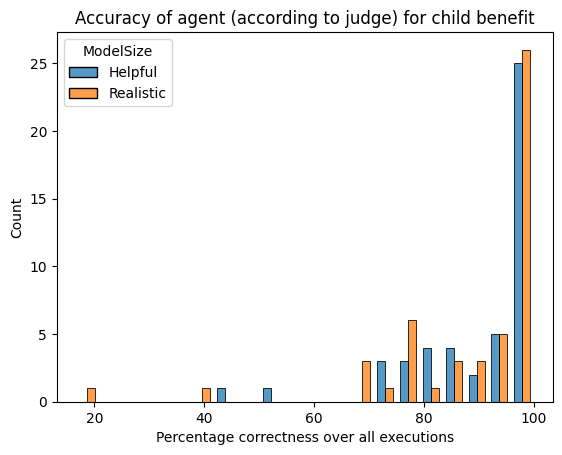

In [63]:
def get_success_rates_by_permutation(combined_df: pd.DataFrame) -> pd.DataFrame:
    df = (
        100
        * combined_df[combined_df[success_column] == True]
        .index.get_level_values(2)
        .value_counts()
        / combined_df.index.get_level_values(2).value_counts()
    )
    print(df.nsmallest(n=15))
    return df


def get_success_rates_by_permutation_model_size(combined_df: pd.DataFrame, test_cohort) -> pd.DataFrame:
    df = (
        100
        * combined_df[combined_df[success_column] == True]
        .index.droplevel(0)
        .droplevel(0)
        .value_counts()
        / combined_df.index.droplevel(0).droplevel(0).value_counts()
    )
    print(df.nsmallest(n=15))
    print(df.reset_index().set_index("permutation").value_counts())

    fig_name = "success_rates_by_permutation_model_size.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    ax = sns.histplot(
        df.reset_index(),
        x="count",
        hue="ModelSize",
        multiple="dodge",
        shrink=0.7,
        bins=20,
        common_bins=True,
    )
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")

    return df


success_rates_by_permutations = get_success_rates_by_permutation(
    combined_dfs
)
success_rates_by_permutation_model_sizes = (
    get_success_rates_by_permutation_model_size(
        combined_dfs, test_cohort
    )
)

count
 0.000000    19
 0.333333     2
 0.037037     1
-0.052632     1
-0.250000     1
 0.161804     1
-0.144444     1
 0.021531     1
-0.262987     1
-0.055556     1
 0.064516     1
-0.143817     1
-0.088889     1
-0.007353     1
 0.250000     1
-0.272727     1
 0.666667     1
 0.062500     1
-0.555556     1
 0.039474     1
 0.026316     1
 0.149784     1
-0.061776     1
-0.052109     1
-0.093750     1
 0.169951     1
-0.006061     1
 0.027778     1
-0.013889     1
Name: count, dtype: int64


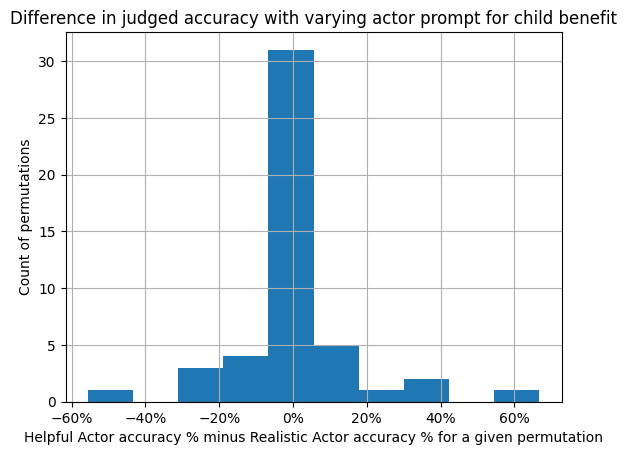

In [64]:
def get_large_model_improvements_by_permutation(
    combined_df_raw: pd.DataFrame,
    test_cohort
) -> pd.DataFrame:
    df = (
        combined_df_raw[
            (combined_df_raw[success_column] == True)
            & (combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["improved"])
        ]
        .index.get_level_values(2)
        .value_counts()
        / combined_df_raw[(combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["improved"])]
        .index.get_level_values(2)
        .value_counts()
    ) - (
        combined_df_raw[
            (combined_df_raw[success_column] == True)
            & (combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["baseline"])
        ]
        .index.get_level_values(2)
        .value_counts()
        / combined_df_raw[(combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["baseline"])]
        .index.get_level_values(2)
        .value_counts()
    )

    fig_name = "success_rates_by_permutation_model_size.improvement.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df.hist()
    ax = fig.get_axes()[0]
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(
        figure_annotations[test_cohort][fig_name]["xlabel"]
    )
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    fig.savefig(
        f"figures/{fig_name}.{test_cohort}.png"
    )
    print(df.value_counts())
    return df

large_model_improvement_by_permutations = (
    get_large_model_improvements_by_permutation(
        combined_dfs_raw, test_cohort
    )
)

Passed  eligible  not_eligible
True    True      False           1538
        False     True             489
False   True      False             85
        False     True              66
True    True      True              22
False   True      True               4
Name: count, dtype: int64


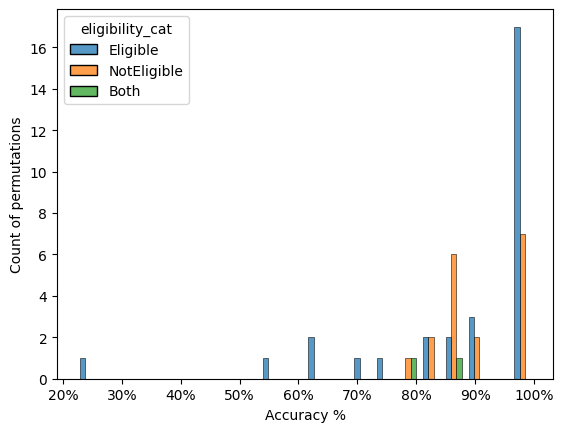

In [65]:
def get_success_rates_by_eligibility(
    success_rates_by_permutation: pd.DataFrame,
    eligibility_df: pd.DataFrame,
    test_cohort,
) -> pd.DataFrame:
    fig_name = "success_rates_by_eligibility.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df = eligibility_df.join(success_rates_by_permutation)
    df["eligibility_cat"] = df.apply(get_eligibility_case, axis=1)

    #  df = df.set_index(["eligible", "not_eligible"], append=True)
    #  df.hist()

    ax = sns.histplot(
        df,
        x="count",
        hue="eligibility_cat",
        multiple="dodge",
        shrink=0.7,
        bins=20,
        common_bins=True,
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(100.0))

    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
    return df

print(
    combined_dfs_raw.value_counts(
        [success_column, "eligible", "not_eligible"]
    )
)
success_rates_by_eligibilitys = get_success_rates_by_eligibility(
    success_rates_by_permutations,
    eligibility_dfs,
    test_cohort,
)

/var/folders/b2/7k_brtrs25x6v118yqs3yt8m0000gp/T/ipykernel_10711/695135691.py:12: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df = df.reset_index().groupby(["eligibility_cat", "ModelSize"], axis=0).mean("count")


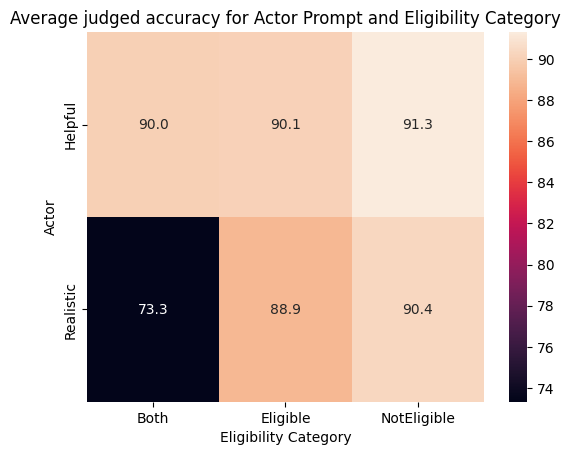

In [66]:
def get_success_rates_by_eligibility_model_size(
    success_rates_by_permutation_model_size: pd.DataFrame,
    eligibility_df: pd.DataFrame,
    test_cohort,
) -> pd.DataFrame:
    fig_name = "success_rates_by_eligibility.modelSize"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df = eligibility_df.join(success_rates_by_permutation_model_size)
    df["eligibility_cat"] = df.apply(get_eligibility_case, axis=1)

    df = df.reset_index().groupby(["eligibility_cat", "ModelSize"], axis=0).mean("count")

    ax = sns.heatmap(
        df.reset_index().pivot(index="ModelSize", columns="eligibility_cat", values="count"),
        annot=True,
        fmt=".1f"
    )

    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    #  ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(100.0))
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )

    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
    return df

success_rates_by_eligibility_model_size = get_success_rates_by_eligibility_model_size(
    success_rates_by_permutation_model_sizes,
    eligibility_dfs,
    test_cohort,
)

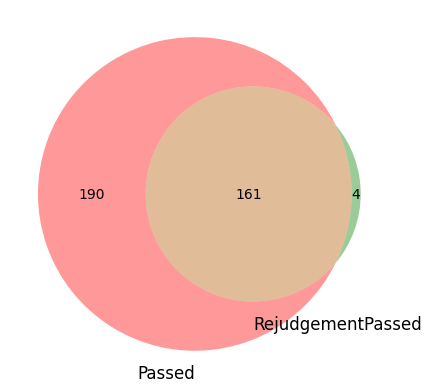

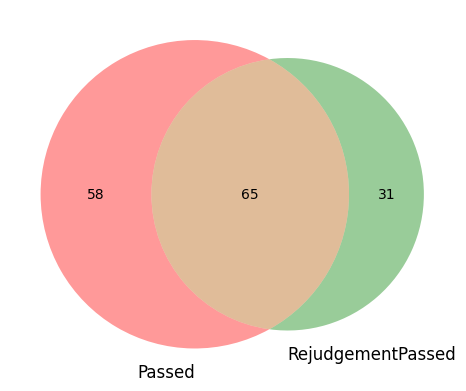

In [67]:
def plot_venn_diagrams(test_cohort, combined_dfs_by_run):
    if "RejudgementPassed" in combined_dfs_by_run and "ConsensusPassed" in combined_dfs_by_run:
        print(combined_dfs_by_run.value_counts(["Passed", "RejudgementPassed", "ConsensusPassed"]))
        fig_name = "venn3_true"
        fig = plt.figure(f"{fig_name}_{test_cohort}")
        fig.clear()
        v = venn3(
            [
                set(combined_dfs_by_run[combined_dfs_by_run["Passed"] == True].index),
                set(combined_dfs_by_run[combined_dfs_by_run["RejudgementPassed"] == True].index),
                set(combined_dfs_by_run[combined_dfs_by_run["ConsensusPassed"] == True].index)
            ],
            ("Passed", "RejudgementPassed", "ConsensusPassed")
        )
        fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
        
        fig_name = "venn3_false"
        fig = plt.figure(f"{fig_name}_{test_cohort}")
        fig.clear()
        v = venn3(
            [
                set(combined_dfs_by_run[combined_dfs_by_run["Passed"] == False].index),
                set(combined_dfs_by_run[combined_dfs_by_run["RejudgementPassed"] == False].index),
                set(combined_dfs_by_run[combined_dfs_by_run["ConsensusPassed"] == False].index)
            ],
            ("Passed", "RejudgementPassed", "ConsensusPassed")
        )
        fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
        #combined_dfs["correct_outcome"] = combined_dfs["reasoning"].str.contains(r"The agent (?:\w+ |\w+ the )?correct", regex=True)
    elif "RejudgementPassed" in combined_dfs_by_run:
        fig_name = "venn2_true"
        fig = plt.figure(f"{fig_name}_{test_cohort}")
        fig.clear()
        v = venn2(
            [
                set(combined_dfs_by_run[combined_dfs_by_run["Passed"] == True].index),
                set(combined_dfs_by_run[combined_dfs_by_run["RejudgementPassed"] == True].index),
            ],
            ("Passed", "RejudgementPassed")
        )
        fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
        
        fig_name = "venn2_false"
        fig = plt.figure(f"{fig_name}_{test_cohort}")
        fig.clear()
        v = venn2(
            [
                set(combined_dfs_by_run[combined_dfs_by_run["Passed"] == False].index),
                set(combined_dfs_by_run[combined_dfs_by_run["RejudgementPassed"] == False].index),
            ],
            ("Passed", "RejudgementPassed")
        )
        fig.savefig(f"figures/{fig_name}.{test_cohort}.png")


combined_dfs_raw = load_and_join_rejudgements(output_dir, test_cohort, combined_dfs_raw) 
combined_dfs_by_run = deduplicate_rejudgements(combined_dfs_raw)
plot_venn_diagrams(test_cohort, combined_dfs_by_run)

In [68]:
#if __name__ == "__main__":
#    main(["child_benefit__stressTestAgent"])

# **Test Execution Observations \- (Poor Quality Responses)**

# **Executive Summary**

TODO

# **Methodology** 

## **1\. What were we trying to answer** 

* Whether responses that more closely reflected the style of responses observed with users would impact accuracy

## **2\. What we tested (plain English)** 

Service: Child Benefit

Setup: 

* One agent-under-test, representing the agent which a user would be communicating with if this were a real service   
  * Backed by the foundation model Claude 3.7  
  * [Prompt provided to agent was simple instructions to hold a conversation with the user to determine their eligibility for the skilled worker visa](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/agents/TechnicalHypotheses/Accuracy-ChildBenefit-v2.md)  
* For the purposes of testing:  
  * An actor agent to take on the role of user based on the prescribed response style   
  * A judge agent to make judgements based on the responses of the agent-under-test   
* no personal data integrations 

Scenarios: 

* 50 scenarios devised by Gemini, by asking it to review the child benefit eligibility guidance and devise scenarios describing all the permutations of that guidance it could think of, representing realistic happy/sad paths   
  Test Executions:  
* A full test execution comprises an execution of each of the 50 scenarios  
* For each test execution, the actor was given one of two prompts  
  * [One was intended to represent the conversation style observed in user testing](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/agents/Ancillary/Actor-Humanlike-v2.md)  
  * [The second was a similar prompt used in previous testing](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/agents/Ancillary/Actor-Humanlike-v0.md)  
* 12 test executions were carried out, 6 of each of the two prompts

Task undertaken within each test: 

* Actor agent takes on persona described by a scenario, converses with agent under test, once agent under test has given an indication of eligibility   
* The judge agent receives the conversation dialogue, compares the outcome with the expected eligibility outcome described in the scenario.  
* If the outcome given by the agent under test matches the expected outcome described in the scenario, and the agent under test has not given any information which the judge agent considers to be incorrect, then the judge agent marks the result as a success.   
* Otherwise, the judge agent marks the result as a failure 

## **3\. What “good” looked like** 

* Agent-under-test does not make any statements which can be considered to be inaccurate with respect to the published government guidance on child benefit eligibility   
* Agent-under-test communicates an indication of eligibility which aligns with the published government guidance on child benefit eligibility  
* No noticeable drop-off in accuracy when “more realistic” responses are given (as assessed by the prompt used)

## **4\. What happened** 

### **Headline result** 

* There was a reduction in accuracy of 5% over all scenarios   
  * 12 scenarios showed a reduction in accuracy of 10-20% but for 2 scenarios the reduction was 40-50%  
  * This suggests that some scenarios were impacted more by the change in response style than others  
* The scenarios in which the expected outcome was “not eligible” observed a higher decrease in accuracy than the scenarios in which the expected outcome was eligible.  
  * This matches the findings observed previously in hypothesis \#1 (comparing large vs small models)  
* There are questions still to be answered as to the extend to which this data is due to randomness

### 

### **Supporting Signals** 

![][image1]

* The above graph shows the percentage decrease in accuracy observed using the “realistic prompt” vs the “helpful prompt”  
  * There are several very large negative values which break the assumption that the helpful prompt will yield more accurate results than the less helpful prompt  
  * The shape of this graph is also very suggestive of a strong random component

**![][image2]**

* The above graph shows the average accuracy results, if we group the scenarios in one of three eligibility “categories”  
  * These categories are:   
    * “Eligible” where the expected outcome is that all of the adults in the scenario will be eligible for child benefit for all children    
    * “NotEligible”: where the expected outcome is that none of the adults in the scenario will be eligible for child benefit for all children  
    * “Both”: where the expected outcome is that only some of the adults in the scenario will be eligible for child benefit, or that all of the adults will be eligible for child benefit for only some of the children  
  * The last category has only two scenarios, so any drop in accuracy could likely be an artifact of this small sample size 

## **5\. What we learned** 

* How the user interacts with the agent does have an impact on overall accuracy.  
  * That this impact is mainly seen in a minority of scenarios

## **6\. How this experiment shaped what we do next** 

* It might be useful to keep the “realistic” actor agent behaviour in future testing to provide more authentic results  
* There may be value in investigating whether there are any patterns of prompts that can elicit better responses from a user, but this is best investigated via user research as there would be no authentic way to simulate this human behaviour

## **7\. Artefacts & useful links** 

* [Scenarios tested](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/manual/test_cases/child_benefit.md)  
* Actor prompts  
  * [Realistic](http://Actor-Humanlike-v2.md)   
  * [Helpful](http://Actor-Humanlike-v0.md)   
* [Judge Prompt](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/agents/Ancillary/EvaluationJudge-EvaluationOnly-v2.md)   
* [Agent Prompt](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/agents/TechnicalHypotheses/Accuracy-ChildBenefit-v2.md) 

		 			 			 			 			 			 			 		 		  
	  


[image1]: <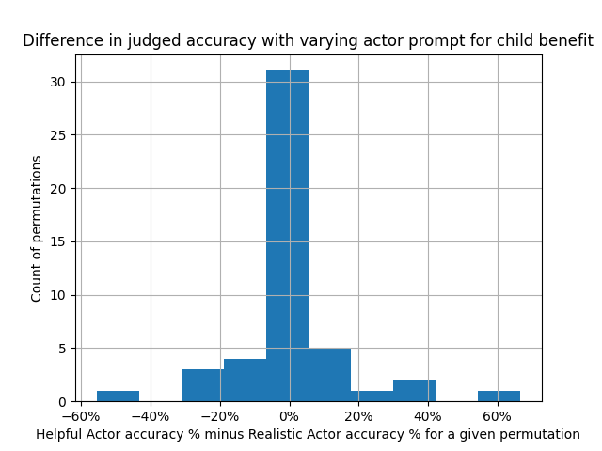>

[image2]: <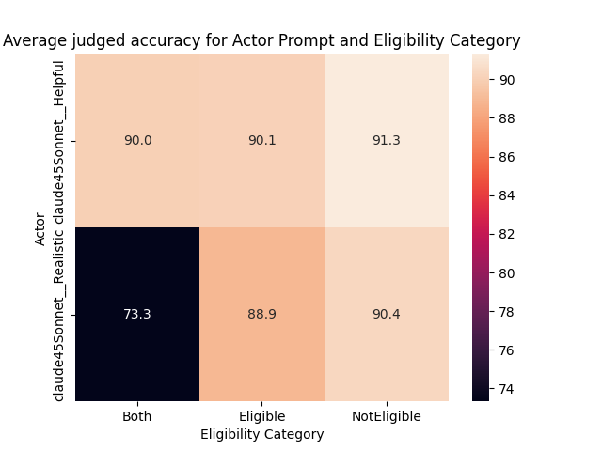>